# IPCC AR6 Interactive Atlas Datalab

***

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Regional averaging of climate information

**M. Iturbide** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook is a reproducibility example for the [**IPCC-WGI AR6 Interactive Atlas**](https://interactive-atlas.ipcc.ch/) products. 

This notebook works with the data available in this Hub. In particular, the **IPCC-WGI AR6 Interactive Atlas Dataset**, originally published at [**DIGITAL.CSIC**](https://digital.csic.es/handle/10261/280324) for the long-term archival, and also available through the **[Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/datasets/projections-climate-atlas?tab=overview)**.

Open the **`Getting_started.ipynb`** for a **description of the available data** and for a quick **introduction to the **[climate4R framework](https://github.com/SantanderMetGroup/climate4R)**, the bundle of R packages used in this notebook.


### Contents in this notebook
1) Libraries
2) Data preparation
3) Application of a land-sea mask
4) Generate regionalized information
***

Before we start, or at any stage of the notebook, we can customize the plotting area within this notebook as follows:

In [1]:
library(repr)
# Change plot size 
options(repr.plot.width=16, repr.plot.height=6)

### 1. Libraries


In [39]:
library(loadeR)
library(transformeR)
library(visualizeR)
library(geoprocessoR)
library(rgdal)
library(lattice)
library(magrittr)
library(RColorBrewer)
library(curl)

Using libcurl 8.10.1 with OpenSSL/3.3.2



### 2. Data Preparation

The aim of this notebook is to illustrate the operations that can be carried out in *climate4R* to synthesize climate information through regionalized statistics. These operations can be applied to any *climate4R* (C4R) grid, containing any type of information. Here, we will demonstrate this using a simple data loading operation to obtain the target C4R grid. For more detailed explanations on data loading, please refer to other notebooks (e.g., `getting started`).

In [3]:
data.paths <- read.csv("../../data_inventory.csv")
str(data.paths)

'data.frame':	1726 obs. of  6 variables:
 $ location  : chr  "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/pr_CORDEX-ANT_histo"| __truncated__ "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/tn_CORDEX-ANT_histo"| __truncated__ "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/rx1day_CORDEX-ANT_h"| __truncated__ "https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CORDEX-ANT/historical/tx_CORDEX-ANT_histo"| __truncated__ ...
 $ type      : chr  "opendap" "opendap" "opendap" "opendap" ...
 $ variable  : chr  "pr" "tn" "rx1day" "tx" ...
 $ project   : chr  "CORDEX-ANT" "CORDEX-ANT" "CORDEX-ANT" "CORDEX-ANT" ...
 $ experiment: chr  "historical" "historical" "historical" "historical" ...
 $ frequency : chr  "mon" "mon" "mon" "mon" ...


* `location` refers to the path 
* `type` refers to the access mode, local (netcdf) or remote (opendap). 
* `variable` referst to the climatic variable or index (i.e. tas, pr, tn, rx1day, etc.)
* `project` refers to the project coordinating the datasets (i.e. CORDEX-EUR, CMIP5, CMIP6, etc.)
* `experiment` referst to the scenario (i.e. historical, rcp26, ssp126, rcp85, etc.)

We can easily apply filters to narrow down to the desired file. In this example the TXx index (maximum of maximum temperatures) from CMIP6,  for the historical and ssp370 experiments. The information piece we need is the `location`.

In [4]:
nc.file.ssp370 <- subset(data.paths, project == "CMIP6" & type == "netcdf" & variable == "txx" & experiment == "ssp370")[["location"]]
nc.file.hist <- subset(data.paths, project == "CMIP6" & type == "netcdf" & variable == "txx" & experiment == "historical")[["location"]]

Before loading the data, we can set common parameters such as the geographical domain, the target season (boreal summer in this example), the reference period for the historical baseline (in this case, the pre-industrial period) and the future period (in this case, the medioum term).

In [5]:
ref.period <- 1850:1900
fut.period <- 2041:2060
lonLim <- c(-11, 40)
latLim <- c(25, 50)
season <- 6:8

Now we load the data for the historical and ssp585 experiments.

In [6]:
cmip6.hist <- loadGridData(nc.file.hist, 
                         var = "txx", 
                         lonLim = lonLim, 
                         latLim = latLim,
                         years = ref.period, 
                         season = season)  %>% suppressWarnings

[2024-11-07 10:36:51.249873] Defining geo-location parameters

[2024-11-07 10:36:51.795392] Defining time selection parameters

[2024-11-07 10:36:51.84402] Retrieving data subset ...

[2024-11-07 10:37:05.282443] Done



In [7]:
cmip6.ssp370 <- loadGridData(nc.file.ssp370, 
                         var = "txx", 
                         lonLim = lonLim, 
                         latLim = latLim,
                         years = fut.period, 
                         season = season)  %>% suppressWarnings

[2024-11-07 10:37:05.451922] Defining geo-location parameters

[2024-11-07 10:37:05.51715] Defining time selection parameters

[2024-11-07 10:37:05.541033] Retrieving data subset ...

[2024-11-07 10:37:09.102625] Done



Before continuing, we must retain the same models (in the same order) in both the future and historical grids. To do so, we apply the `intersectGrid` function. 

In [35]:
cmip6.common.mems <- intersectGrid(cmip6.hist, cmip6.ssp370, type = "members", which.return = 1:2)
cmip6.hist <- cmip6.common.mems[[1]] ; cmip6.ssp370 <- cmip6.common.mems[[2]]

It is always a good practice to make sure that the members in both grids are identical:

In [36]:
identical(cmip6.hist$Members, cmip6.ssp370$Members)

[1] TRUE

Calculate the climate change signal with the `gridArithmetics` function.

In [11]:
delta <- gridArithmetics(climatology(cmip6.ssp370), climatology(cmip6.hist), operator = "-")

[2024-11-07 10:37:09.278633] - Computing climatology...

[2024-11-07 10:37:09.528503] - Done.

[2024-11-07 10:37:09.996502] - Computing climatology...

[2024-11-07 10:37:10.319743] - Done.



Plot the map with `spatialPlot`.

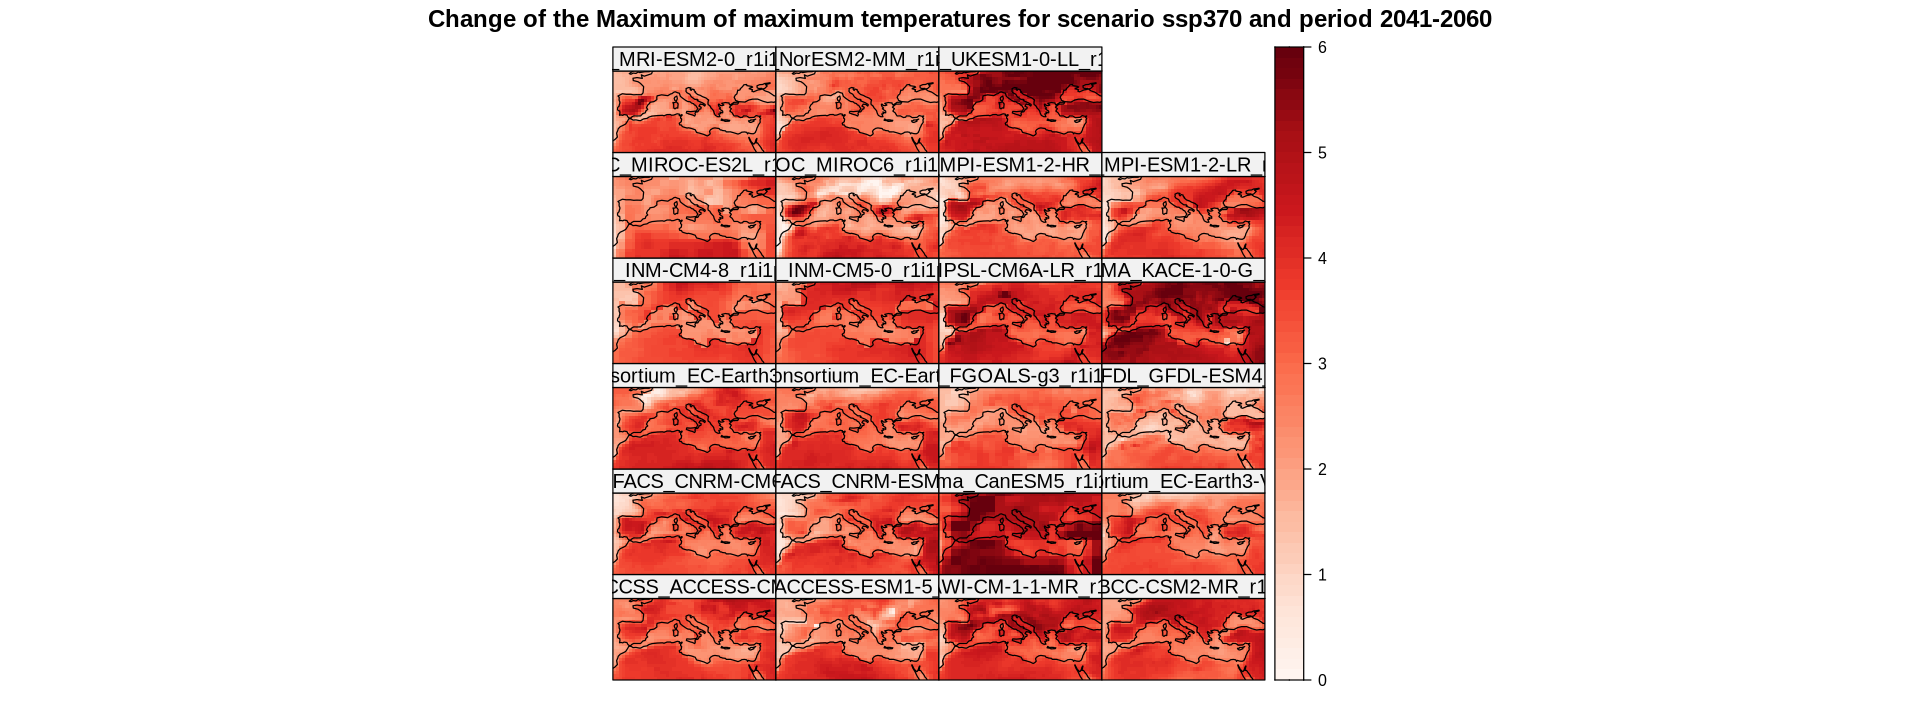

In [12]:
spatialPlot(delta, 
            backdrop.theme = "coastline", 
            at = seq(0, 6, 0.1), 
            set.max = 6, 
            set.min = 0,
            color.theme = "Reds",
            main = "Change of the Maximum of maximum temperatures for scenario ssp370 and period 2041-2060",
            strip = strip.custom(factor.levels = delta$Members))

Calculate and plot the map of the ensemble mean.

In [13]:
delta.ens.mean <- aggregateGrid(delta, aggr.mem = list(FUN = mean))

[2024-11-07 10:37:14.472943] - Aggregating members...

[2024-11-07 10:37:14.48203] - Done.



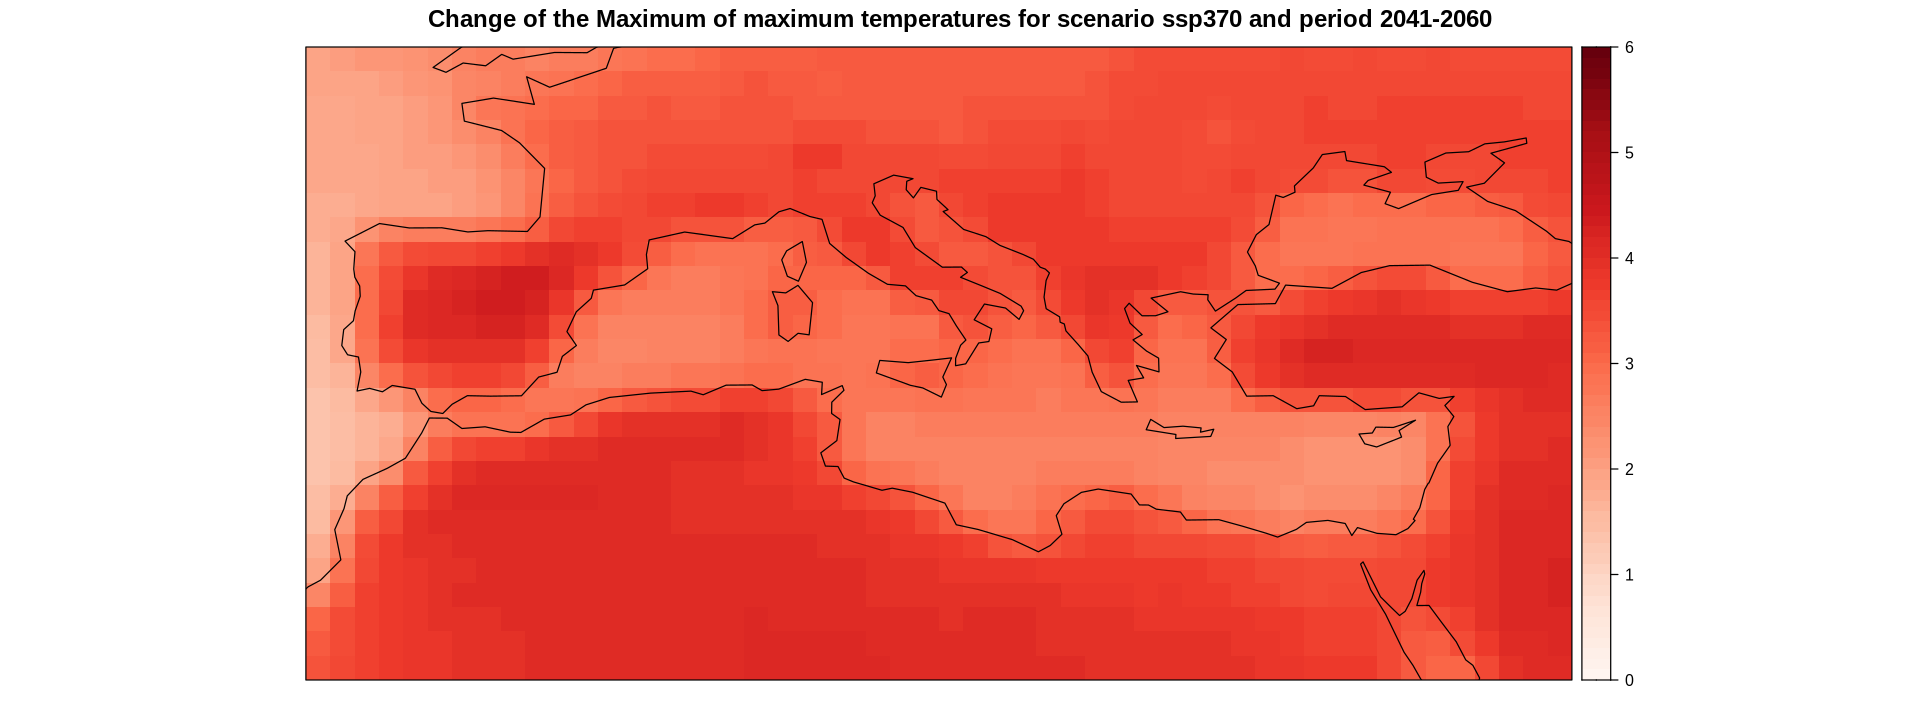

In [14]:
spatialPlot(delta.ens.mean, 
            backdrop.theme = "coastline", 
            at = seq(0, 6, 0.1), 
            set.max = 6, 
            set.min = 0,
            color.theme = "Reds",
            main = "Change of the Maximum of maximum temperatures for scenario ssp370 and period 2041-2060",
            strip = strip.custom(factor.levels = delta$Members))

### 3. Application of a land-sea mask

The land-sea masks necessary for this dataset are accessible in the IPCC-WGI/Atlas GitHub repository, which is mirrored here. Given that the CMIP6 data within the IPCC-WGI AR6 Interactive Atlas dataset adopts a consistent 1-degree grid, it is essential to reference the 1-degree mask (`land_sea_mask_1degree.nc4`) located in the same GitHub repository where the warming level information is available, this is the  [**IPCC-WGI/Atlas GitHub repository**](https://github.com/IPCC-WG1/Atlas/tree/main/warming-levels). Therefore we can load this mask also remotely and using the `lonLim` and `latLim` parameters defined previously.
The variable name is `sftlf` in this case. 

In [41]:
url <- "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/reference-grids/land_sea_mask_1degree.nc4"
temp.file <- tempfile(fileext = ".nc")
curl_download(url, temp.file)

In [42]:
mask <- loadGridData(temp.file,
                    var = "sftlf",
                    lonLim = lonLim, 
                    latLim = latLim)

[2024-11-07 14:46:36.966025] Defining geo-location parameters

[2024-11-07 14:46:37.035901] Defining time selection parameters

NOTE: Undefined Dataset Time Axis (static variable)

[2024-11-07 14:46:37.047954] Retrieving data subset ...

[2024-11-07 14:46:37.114017] Done



After loading the mask, we need to apply a threshold to the resulting grid to make it binary. In this example, we want to retain the data over the land areas. Therefore, we will set sea grid cells as `NA` (values below the threshold are positioned first in the `values` parameter), and land grid cells will be set to `1`.

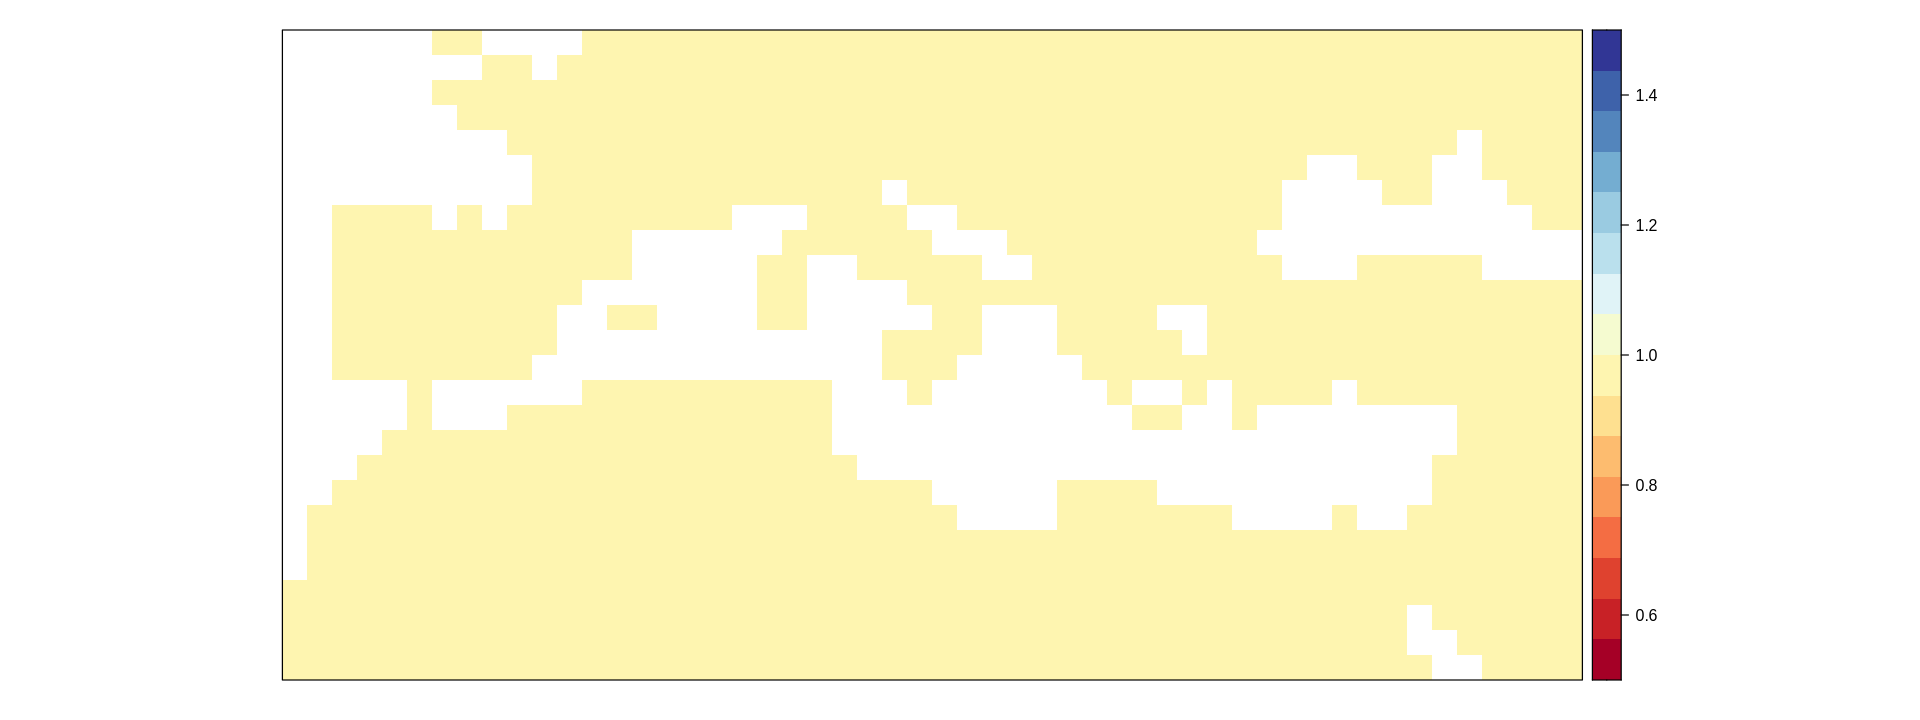

In [16]:
mask <- binaryGrid(mask, condition = "GT", threshold = 0.5, values = c(NA, 1))
spatialPlot(mask)

To apply the mask, we can utilize the `gridArithmetics` function directly.

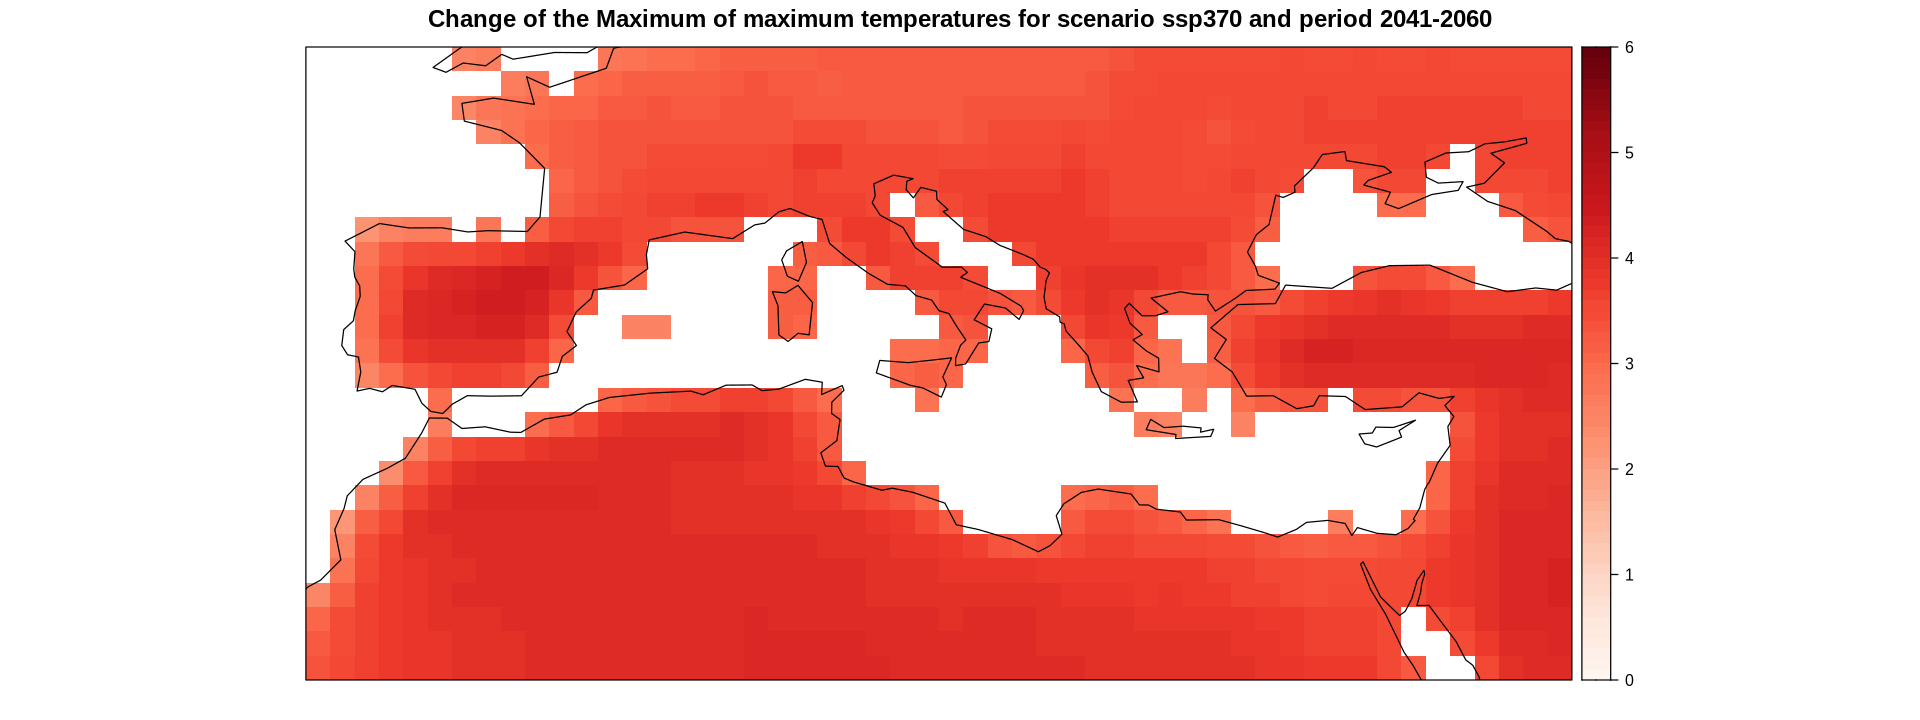

In [17]:
delta.ens.mean.land <- gridArithmetics(delta.ens.mean, mask, operator = "*")
spatialPlot(delta.ens.mean.land, 
            backdrop.theme = "coastline", 
            at = seq(0, 6, 0.1), 
            set.max = 6, 
            set.min = 0,
            color.theme = "Reds",
            main = "Change of the Maximum of maximum temperatures for scenario ssp370 and period 2041-2060")

To apply the same mask to the multi-model grid, a trick can be employed to duplicate the mask for each member in the target grid using the `rep` function. The expression `getShape(delta, "member")` returns the number of members in the `delta` grid. The resulting grid is a list with a length equal to the number of members, where each slot contains the same mask grid. Afterwards, `binaryGrid` is used to bind them all along the member dimension.

In [18]:
multi.mask <- rep(list(mask), getShape(delta, "member")) %>% bindGrid(dimension = "member", skip.temporal.check = T)

Now we are ready to apply `gridArithmetics`, as the dimension lengths are now the same in both the target grid and the mask grid.

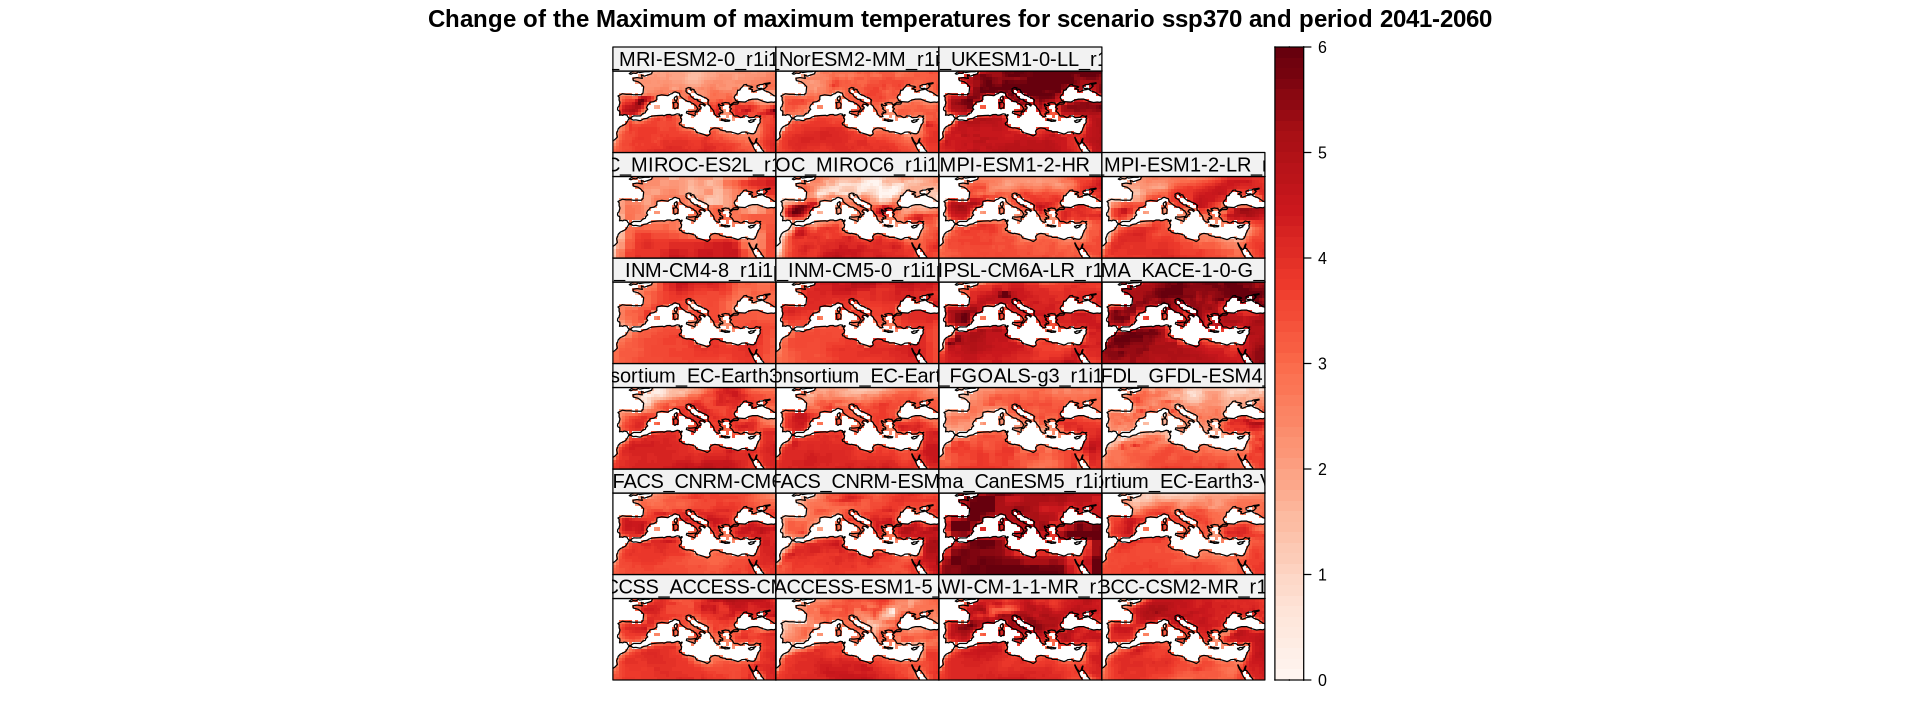

In [19]:
delta.land <- gridArithmetics(delta, multi.mask, operator = "*")
spatialPlot(delta.land, 
            backdrop.theme = "coastline", 
            at = seq(0, 6, 0.1), 
            set.max = 6, 
            set.min = 0,
            color.theme = "Reds",
            main = "Change of the Maximum of maximum temperatures for scenario ssp370 and period 2041-2060",
            strip = strip.custom(factor.levels = delta$Members))

### 4. Generate regionalized information

To get regionalized outcomes, we could consider any region within our study area. In this example, we use one of the IPCC-WGI Reference Regions available at [**IPCC-WGI/Atlas GitHub repository**](https://github.com/IPCC-WG1/Atlas/tree/main/warming-levels). 

In [20]:
ref.regs <- readOGR("https://raw.githubusercontent.com/IPCC-WG1/Atlas/refs/heads/main/reference-regions/IPCC-WGI-reference-regions-v4.geojson") %>%
                suppressWarnings

OGR data source with driver: GeoJSON 
Source: "https://raw.githubusercontent.com/IPCC-WG1/Atlas/refs/heads/main/reference-regions/IPCC-WGI-reference-regions-v4.geojson", layer: "IPCC-WGI-reference-regions-v4"
with 58 features
It has 5 fields


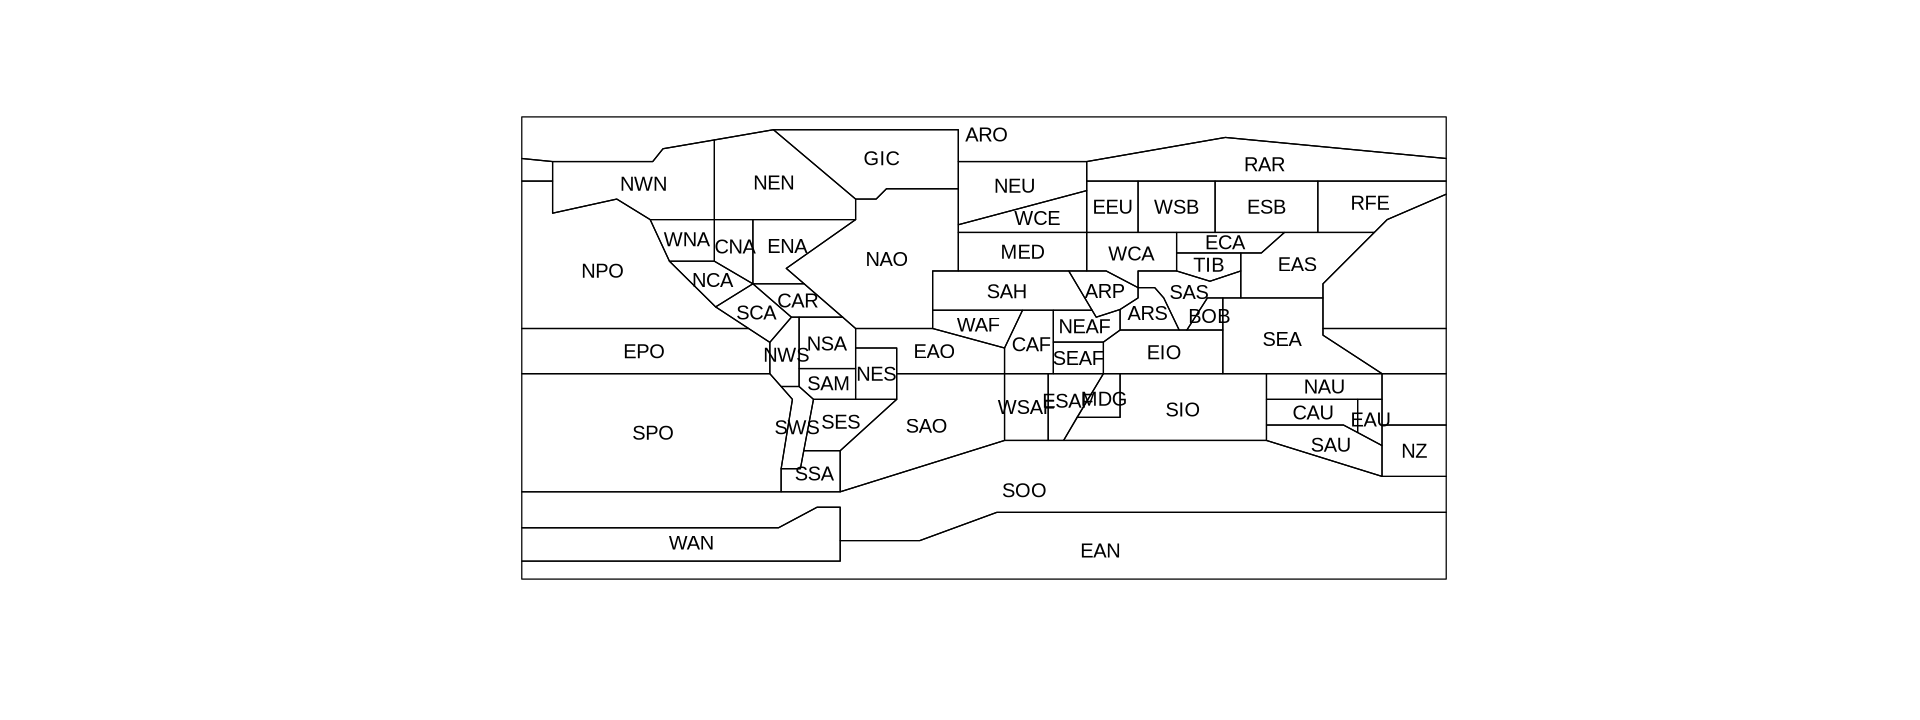

In [21]:
plot(ref.regs)
text(coordinates(ref.regs)[,1], coordinates(ref.regs)[,2], ref.regs$Acronym)

These regions can be added as a layer when plotting the map with `spatialPlot`. We do this by passing `list(ref.regs, first = FALSE)` to the `sp.layout` parameter. Note that the regions are passed inside a list, where other parameters can be added, such as `first = FALSE` to overlay the layer on top, or others to adjust line width, color, etc. 

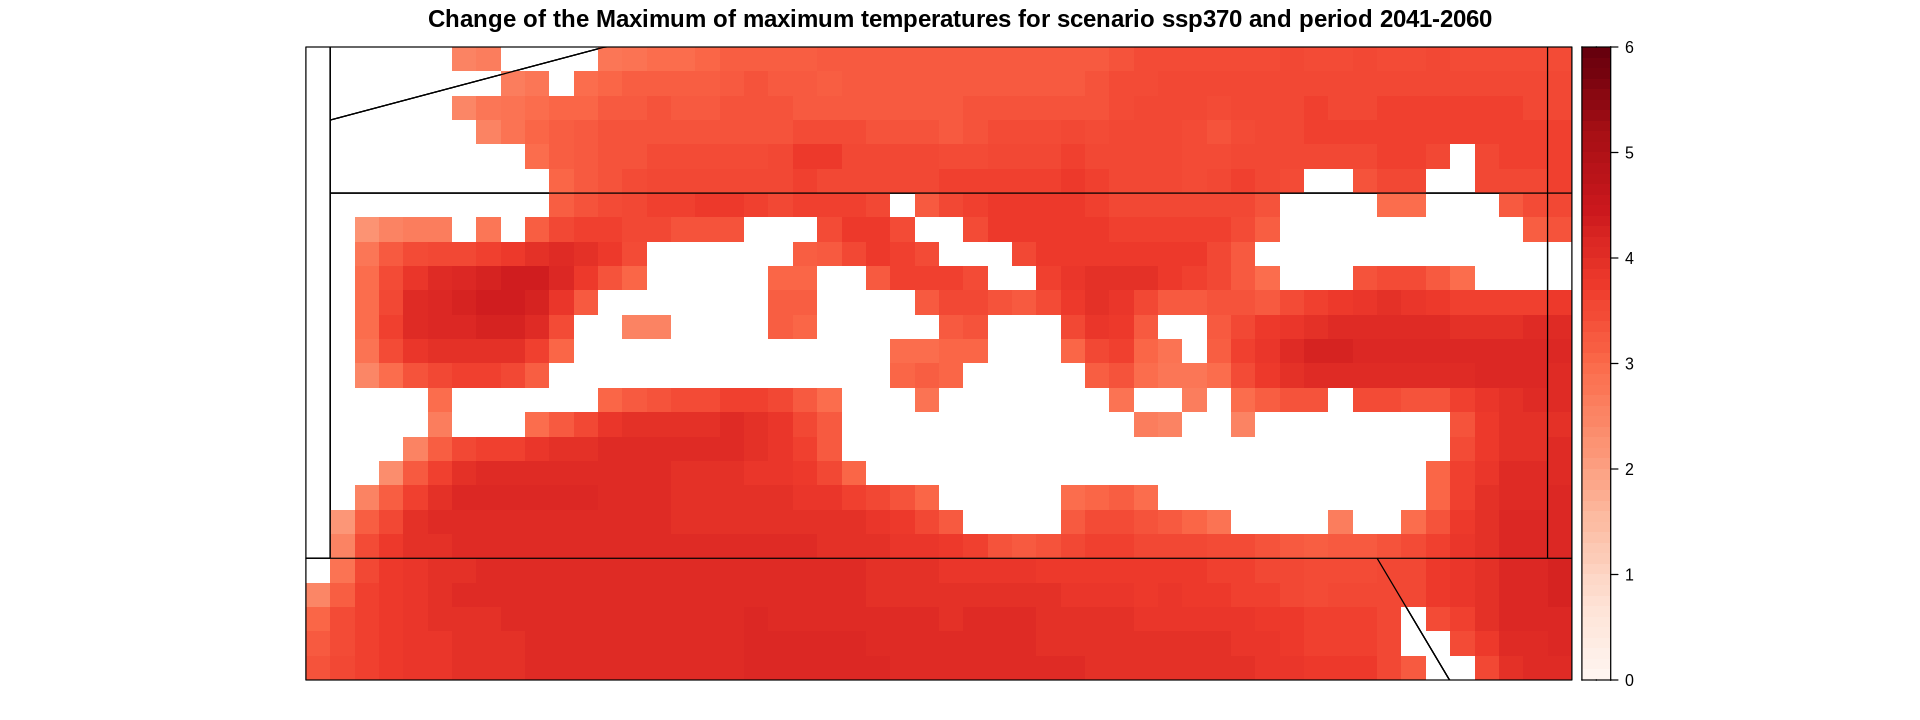

In [22]:
spatialPlot(delta.ens.mean.land, 
            at = seq(0, 6, 0.1), 
            set.max = 6, 
            set.min = 0,
            color.theme = "Reds",
            main = "Change of the Maximum of maximum temperatures for scenario ssp370 and period 2041-2060",
            sp.layout = list(ref.regs, first = F))

In this example we are going to focus on the *Mediterranean* (MED).

In [23]:
med <- subset(ref.regs, Acronym == "MED") %>% as("SpatialPolygons")

The grids here loaded indicate they are "LatLonProjection":

In [24]:
attr(delta.ens.mean.land$xyCoords, "projection")

[1] "LatLonProjection"

The reference regions projections is...

In [25]:
proj4string(med)

[1] "+proj=longlat +datum=WGS84 +no_defs"

Although they may seem different, `LatLonProjection` in the IA-Dataset is equivalent to `+proj=longlat +datum=WGS84 +no_defs`. Therefore, we redefine the projection to allow for the subsequent intersection.

In [26]:
attr(delta.ens.mean.land$xyCoords, "projection") <- proj4string(med)

Now we are ready for the intersection. Apply the `overGrid` function.

In [27]:
delta.ens.mean.land.med <- overGrid(delta.ens.mean.land, layer = med)

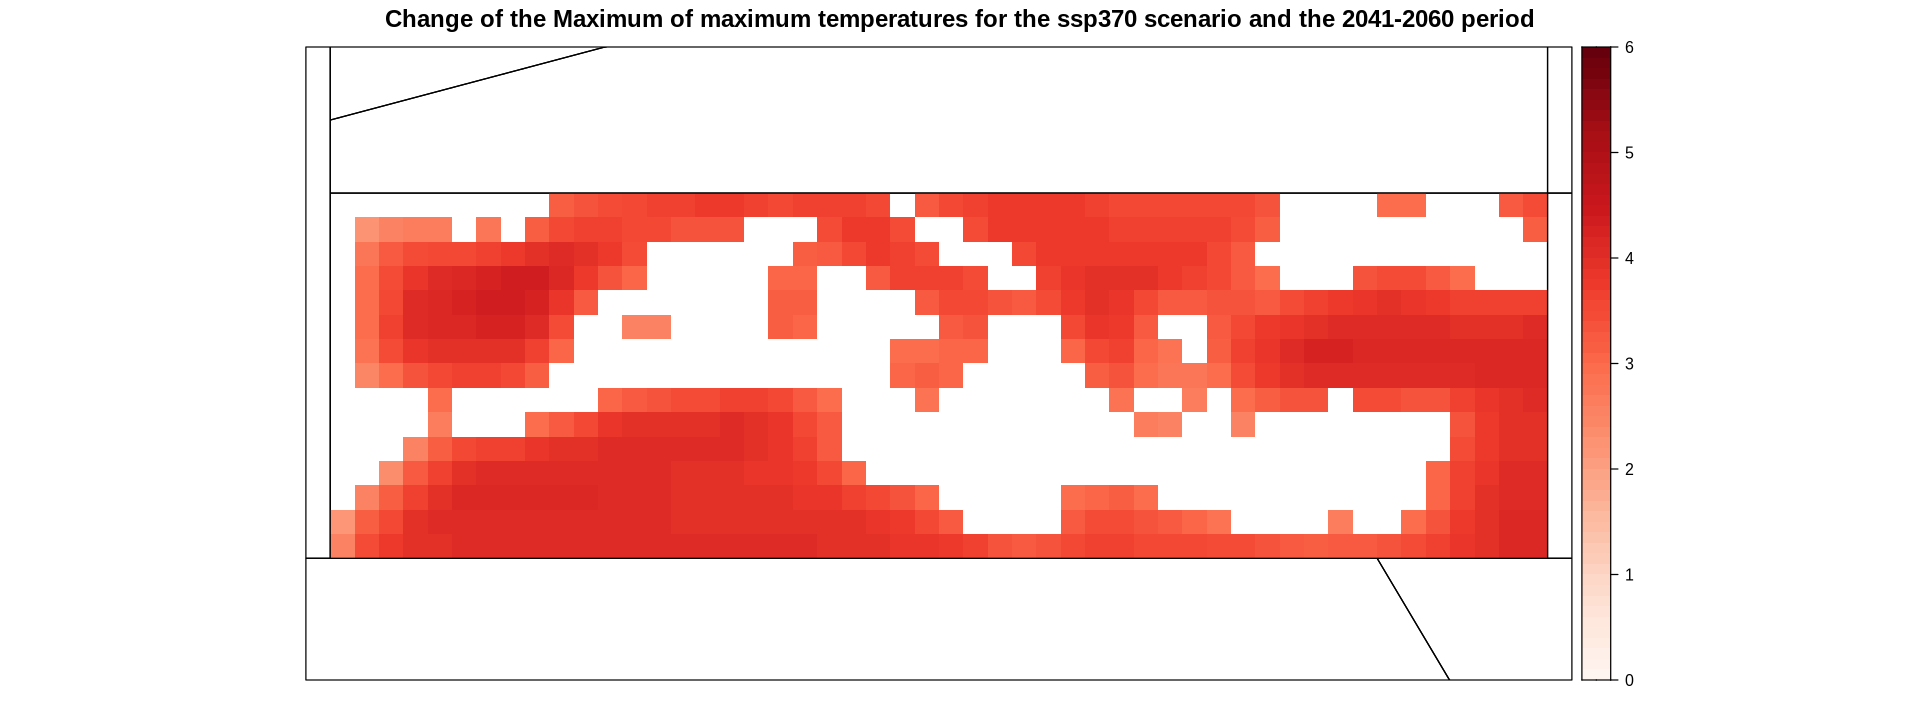

In [28]:
spatialPlot(delta.ens.mean.land.med, 
            at = seq(0, 6, 0.1), 
            set.max = 6, 
            set.min = 0,
            color.theme = "Reds",
            main = "Change of the Maximum of maximum temperatures for the ssp370 scenario and the 2041-2060 period",
            sp.layout = list(ref.regs, first = F))

Next, we show an example of generating regional stripes, although other visualizations could also be created. First, we average the data yearly using the `aggregateGrid` function, which returns yearly data of winter precipitation averages (3-month averages). Next, we calculate the historical climatology to serve as the reference baseline.

Following a similar approach to the one used earlier for the land mask application, we duplicate the historical climatology for each time step in the future yearly data to ensure consistent array dimensions. This allows for calculating yearly anomalies relative to the historical climatology using the `gridArithmetics` function. In other words, the historical climatology is subtracted from each future year of the projections.

In [29]:
cmip6.ssp370.y <- aggregateGrid(cmip6.ssp370, aggr.y = list(FUN = "mean", na.rm = TRUE))
cmip6.hist.c <- climatology(cmip6.hist)
cmip6.hist.multi.year <- rep(list(cmip6.hist.c), getShape(cmip6.ssp370.y, "time")) %>% bindGrid(dimension = "time")
year.delta <- gridArithmetics(cmip6.ssp370.y, cmip6.hist.multi.year, operator = "-")

[2024-11-07 10:37:24.580067] Performing annual aggregation...

[2024-11-07 10:37:29.598088] Done.

[2024-11-07 10:37:29.659808] - Computing climatology...

[2024-11-07 10:37:30.56635] - Done.



To perform spatial aggregations we only need to apply the function `aggregateGrid` again but with the appropriate parameters.

In [30]:
regional.mean <- aggregateGrid(year.delta, aggr.spatial = list(FUN = "mean", na.rm = TRUE))

Calculating areal weights...

[2024-11-07 10:37:31.282897] - Aggregating spatially...

[2024-11-07 10:37:31.318585] - Done.



The function `stripePlot` performs the same spatial aggregation internally and plots the stripes. 

Calculating areal weights...

[2024-11-07 10:37:31.344606] - Aggregating spatially...

[2024-11-07 10:37:31.379066] - Done.



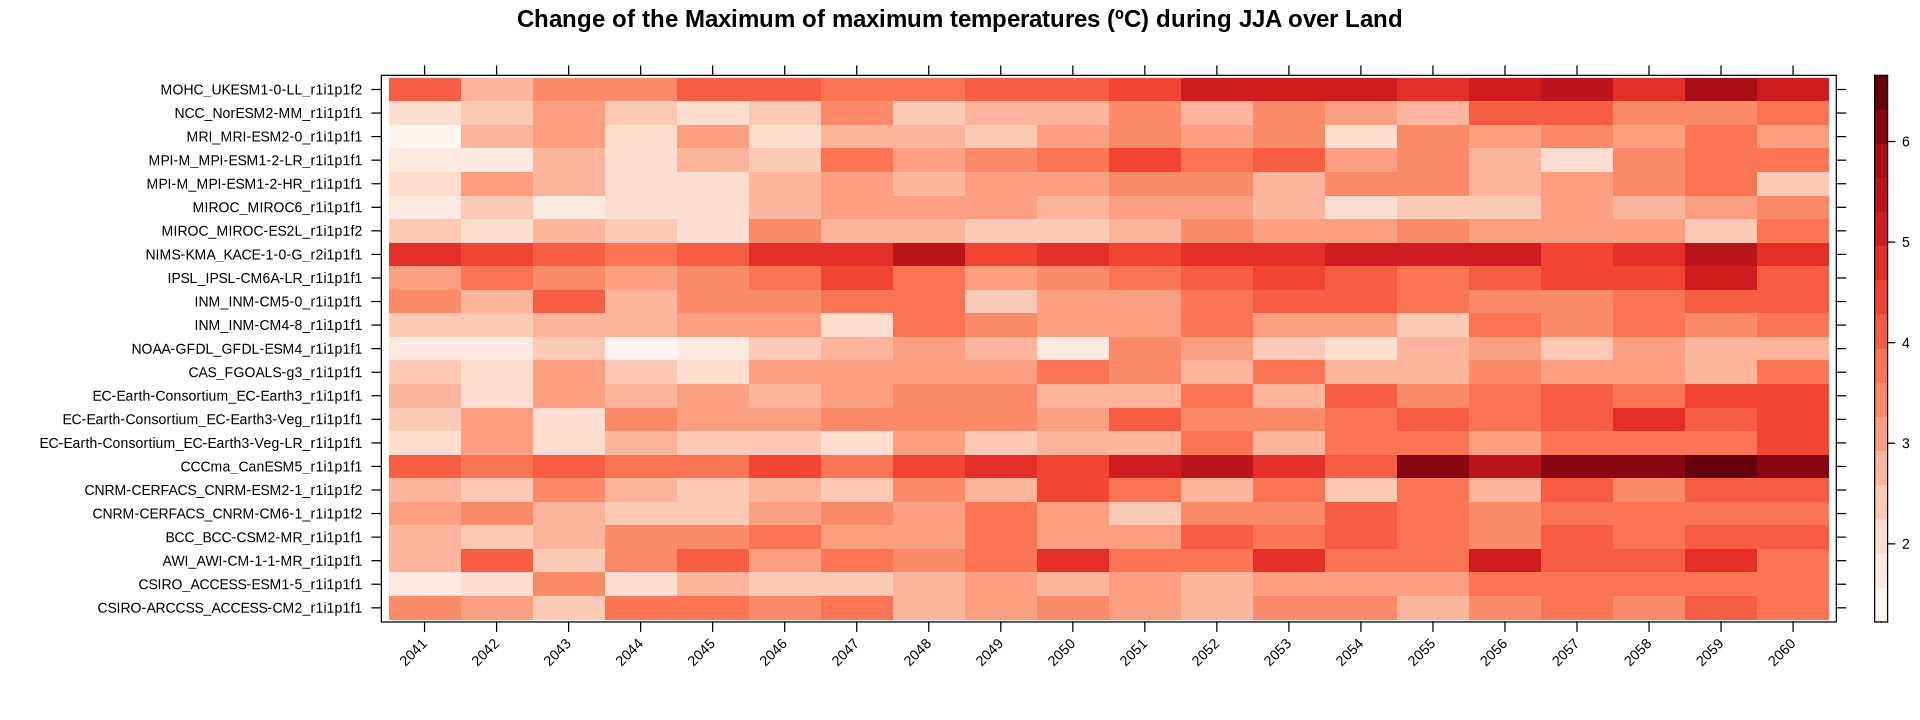

In [31]:
stripePlot(year.delta, 
           aggr.spatial = list(FUN = "mean", na.rm = TRUE), 
           main = "Change of the Maximum of maximum temperatures (ºC) during JJA over Land",
           color.theme = "Reds",
           rev.colors = FALSE)

Next the stripes of the historical reference are plotted.

[2024-11-07 10:37:31.582012] Performing annual aggregation...

[2024-11-07 10:37:41.589599] Done.

Calculating areal weights...

[2024-11-07 10:37:41.630434] - Aggregating spatially...

[2024-11-07 10:37:42.266306] - Done.



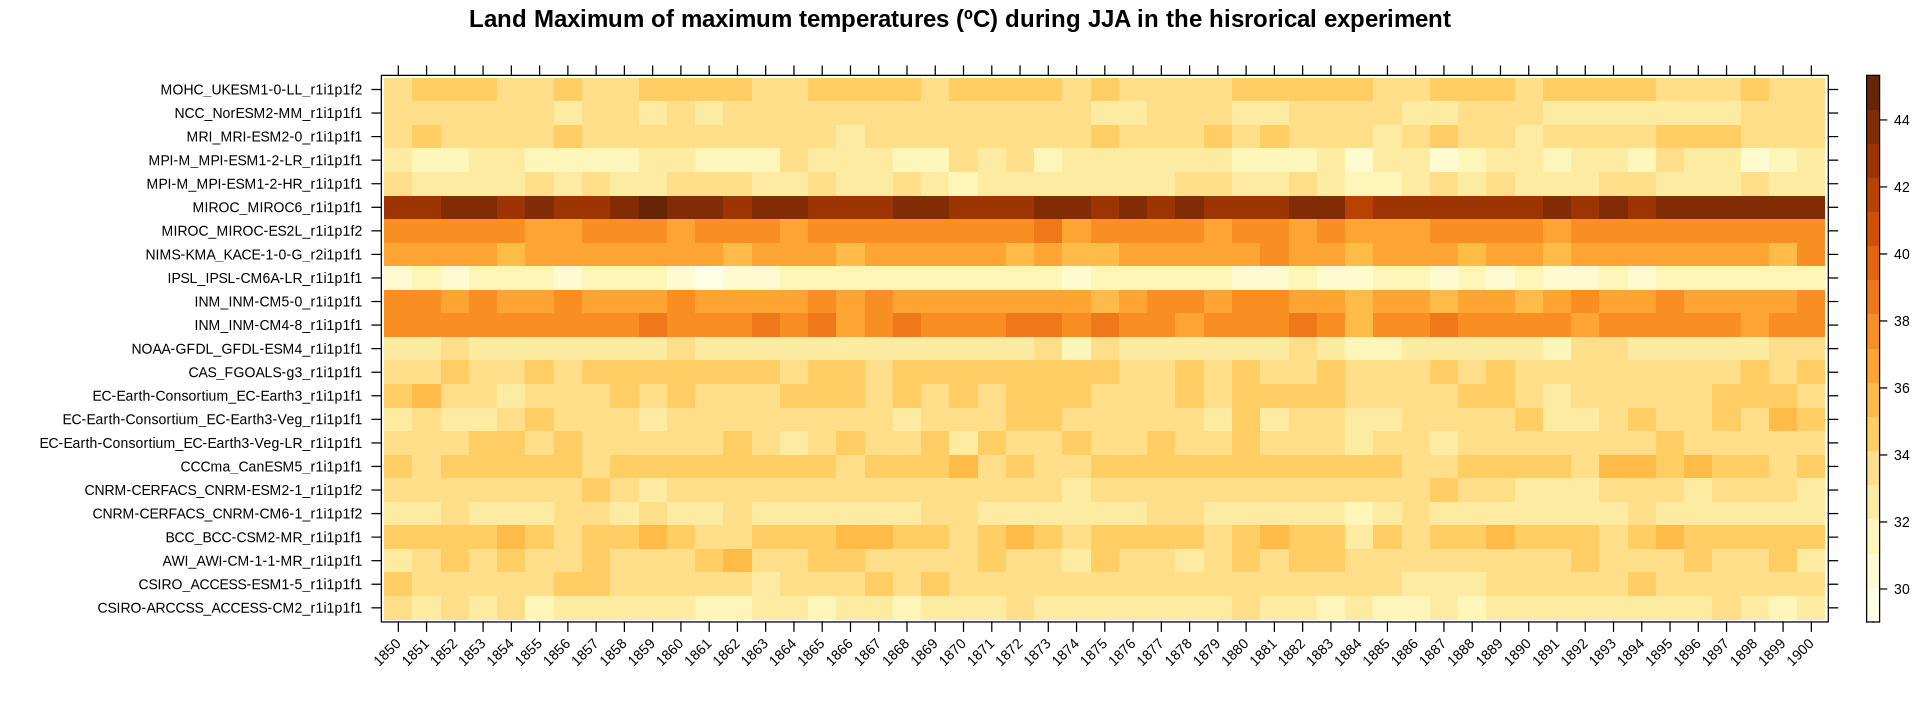

In [32]:
stripePlot(aggregateGrid(cmip6.hist, aggr.y = list(FUN = "mean", na.rm = TRUE)), 
           main = "Land Maximum of maximum temperatures (ºC) during JJA in the hisrorical experiment",
           color.theme =  "YlOrBr")

### Session Info

In [34]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/climate4r/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3  magrittr_2.0.3      lattice_0.22-6     
 [4] rgdal_1.6-7         sp_2.1-4            geoprocessoR_0.2.2 
 [7] visualizeR_1.6.4    transformeR_2.2.2   loadeR_1.8.1       
[10] clim